# Ví dụ về Multilayer Perceptron với tập MNIST
Xây dựng mạng fully connected với 2 lớp ẩn sử dụng Keras

## Tổng quan về Neural Network

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>

## Tập dữ liệu MNIST

Ví dụ này sử dụng tập ảnh chữ số viết tay MNIST. MNIST gồm 60,000 ảnh cho huấn luyện và 10,000 ảnh cho kiểm thử mô hình. Mọi ảnh chữ số viết tay trong tập dữ liệu được chuẩn hóa về kích thước, cụ thể là (28x28) với giá trị pixels nằm trong khoảng 0 đến 1. Để đơn giản bài troán, mỗi ảnh được trải phẳng thành mảng numpy một chiều (784 thành phần)

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

Tham khảo: http://yann.lecun.com/exdb/mnist/

In [42]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras import backend as K
from keras.models import model_from_json
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras import backend

In [43]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [44]:
import keras
keras.__version__

'2.4.3'

## Lập trình mạng nơ-ron với Keras

Thư viện Keras hỗ trợ lập trình mạng nơ-ron rất dễ dàng. Dễ dàng thêm các layer bằng cách sử dụng các đối tượng như Dense(), Dropout(),... 

Xem thêm các hàm cơ bản xây dựng mạng nơ-ron: https://keras.io/layers/core/

Hàm dưới đây xây dựng một mạng nơ-ron Sequantial model của Keras với đầu vào là kích thước ảnh sau khi duỗi về 1D, số lượng lớp (ở đây là 10). Đầu ra là model mạng cho bài toán MNIST.

In [45]:
# Sequential API
# Functional API
def mnist_mlp(img_shape=(784,), num_classes=10):
    model = Sequential()
    
    model.add(Dense(256, activation='relu', input_shape=img_shape))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

Ta có thể dùng hàm summary() để xem lại tổng quát cấu trúc mạng vừa xây dựng, số lượng tham số...

In [46]:
model = mnist_mlp()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


### Tải về dữ liệu MNIST

In [47]:
import tensorflow as tf

# Import MNIST data
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

### Tiếp theo ta sẽ tiến hành huấn luyện mạng nơ-ron cơ bản.

Đối với mạng nơ-ron cơ bản, đầu vào sẽ là một tầng layer 1D, vì thế ta cần duỗi ảnh từ 2D về 1D ((28,28) -> (784,)).

Nhãn y_train và y_test được chuyển về dạng one-hot vector để tiện huấn luyện.

In [48]:
# x_train = x_train/255
# x_test = x_test/255

# # one hot
# num_classes = 10 # Tổng số lớp của MNIST (các số từ 0-9)

# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

# print(x_train.shape)
# print(x_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [49]:
num_classes = 10

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train, x_test_new, y_train, y_test_new = train_test_split(x_train, y_train, test_size=0.66, random_state=42)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('categorical y_train: ', y_train.shape)
print('categorical y_test : ', y_test.shape)

60000 train samples
10000 test samples
categorical y_train:  (20400, 10)
categorical y_test :  (10000, 10)


In [50]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Trong Keras ta sử dụng hàm compile để thiết lập các tham số huấn luyện cho mạng:
- loss: hàm mất mát - https://keras.io/losses/
- optimizer: phương pháp tối ưu - https://keras.io/optimizers/
- metrics: phương pháp đánh giá mô hình - https://keras.io/metrics/
- ...

Sau khi compile thì ta dùng hàm fit để truyền data vào huấn luyện. Một số tham số cần quan tâm:
- batch_size: kích thước batch khi train
- epochs: số lượng lượt train
- validation_data: data cho validation nếu có
- ...

Dưới đây ta sẽ thử huấn luyện mạng

### Siêu tham số

In [51]:
learning_rate = 0.1
num_epoch = 10
batch_size = 128

## Xây dựng mô hình

In [52]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=learning_rate),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/10
160/160 [==============================] - 2s 10ms/step - loss: 0.7860 - accuracy: 0.7732 - val_loss: 0.3745 - val_accuracy: 0.8948
Epoch 2/10
160/160 [==============================] - 2s 10ms/step - loss: 0.3646 - accuracy: 0.8931 - val_loss: 0.2650 - val_accuracy: 0.9217
Epoch 3/10
160/160 [==============================] - 1s 9ms/step - loss: 0.2913 - accuracy: 0.9153 - val_loss: 0.2154 - val_accuracy: 0.9357
Epoch 4/10
160/160 [==============================] - 1s 9ms/step - loss: 0.2489 - accuracy: 0.9276 - val_loss: 0.1993 - val_accuracy: 0.9402
Epoch 5/10
160/160 [==============================] - 1s 9ms/step - loss: 0.2154 - accuracy: 0.9373 - val_loss: 0.1784 - val_accuracy: 0.9452
Epoch 6/10
160/160 [==============================] - 1s 9ms/step - loss: 0.1930 - accuracy: 0.9429 - val_loss: 0.1546 - val_accuracy: 0.9521
Epoch 7/10
160/160 [==============================] - 1s 9ms/step - loss: 0.1736 - accuracy: 0.9487 - val_loss: 0.1474 - val_accuracy: 0.9555
Epoc

### Vẽ đồ thị kết quả quá trình huấn luyện

In [53]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


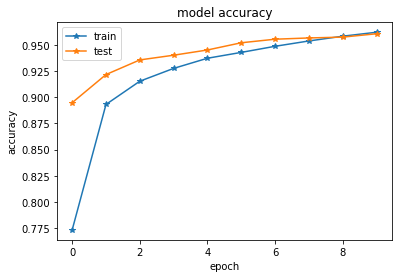

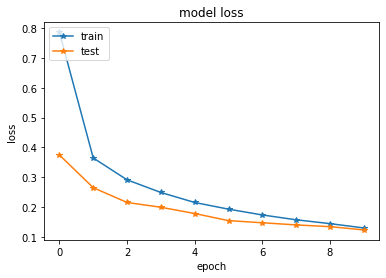

In [54]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], marker = "*")
plt.plot(history.history['val_accuracy'], marker = "*")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], marker = "*")
plt.plot(history.history['val_loss'], marker = "*")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Kiểm thử mô hình

In [55]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12341545522212982
Test accuracy: 0.9606999754905701


### Như vậy model mạng nơ-ron cơ bản đạt độ chính xác khoảng 97.88%. Ta có thể lưu lại mô hình đã huấn luyện để sử dụng sau này:

In [56]:
# Save architecture and weight
with open('mnist_mlp.json', 'w') as f:
    f.write(model.to_json())
model.save_weights("mnist_mlp_weight.h5")

# Load trained model
json_file = open('mnist_mlp.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("mnist_mlp_weight.h5")
loaded_model.summary()

# Re-compile and evaluate model
loaded_model.compile(optimizer=keras.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.1234 - accuracy: 0.9607
Test loss: 0.123415455222

### Dự đoán một vài điểm dữ liệu

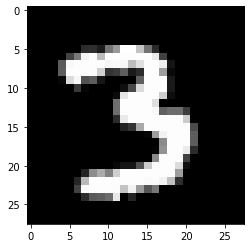

In [57]:
plt.imshow(x_test[500].reshape(28,28), cmap='gray')

In [58]:
result = model.predict(x_test[500].reshape((1,784)))
print(result)

[[7.1960997e-09 4.0604533e-07 8.8668536e-08 9.9998534e-01 2.3865527e-09
  1.0355207e-05 3.4969624e-11 5.5324712e-08 6.6463303e-07 3.0703200e-06]]


In [59]:
np.argmax(result)

3